In [1]:
import os
from os.path import expanduser
import socket
import sys


# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
if running_system == systemLOCAL:
    print "computer = ", running_system
    wd_path = os.path.join(my_home,"Documents","projects", "pyfesom")
elif running_system[0:1] == "b" or running_system == systemHLRN:
    print "computer = ", running_system
    wd_path = os.path.join(my_home,"pyfesom")
else:
    print 'please configure your local machine : type socket.gethostname()'
print "working directory set to", wd_path
os.chdir(wd_path)
# IMPORT PY-FESOM MODULES
sys.path.append("codes/modules")
sys.path.append("codes/pyfesom-master/") # add pyfesom to search path
#########################################

computer =  blogin1
working directory set to /home/hbkoziel/pyfesom


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pylab import *
from load_mesh_data_new import *
import numpy as np
import datetime as dt
from PiecewiseNorm import PiecewiseNorm
from netCDF4 import Dataset
#import colormaps as cmaps
from matplotlib.colors import ListedColormap
import pyfesom as pf

No joblib
no cmocean


In [3]:
# PLOT CONFIGURATION #


# figure export 
export_plot = True
# figure export definition
dpicnt=150
# choose simulation
runid='Arc12'
# choose date
first_year = 2000
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
months =np.linspace(0,11,12).astype(int)
# choose depth
get3d = False
# export CSV
export_csv = True
# load the given biological tracer #
var_id1, var_id2 = 'u','v'
var_id3, var_id4 = 'uu','vv'
# load colormaps #
cmap = plt.get_cmap('RdYlBu_r',len(years))

########################

# AUTOMATIC DEFINITION OF PATHS
resultpath = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/Oldfiles/'
savepath    = wd_path+'/figures/'+runid+'/'
meshpath    = wd_path+'/data/mesh/meshArc4.5/'
outputpath = '/scratch/usr/hbkoziel/Arc12/CSV/'

# Create figure directory if it does not exist
if os.path.exists(savepath) == False:
    try:
        os.mkdir(savepath)
        print ("Creation of the directory %s successfull" % savepath)
    except OSError:
        print ("Creation of the directory %s failed" % savepath)
else:
    print ("directory %s already existing" % savepath)

directory /home/hbkoziel/pyfesom/figures/Arc12/ already existing


In [4]:
mesh = pf.load_mesh(meshpath, usepickle=True,get3d=get3d)

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [5]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [6]:
print('loading index...')
df = pd.read_csv('/home/hbkoziel/awi-models/data/mesh/meshArc4.5/bioregion_index_latlon.csv', delimiter=',',header=0)
print('DONE')
#df.head()

loading index...
DONE


In [7]:
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')

In [8]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


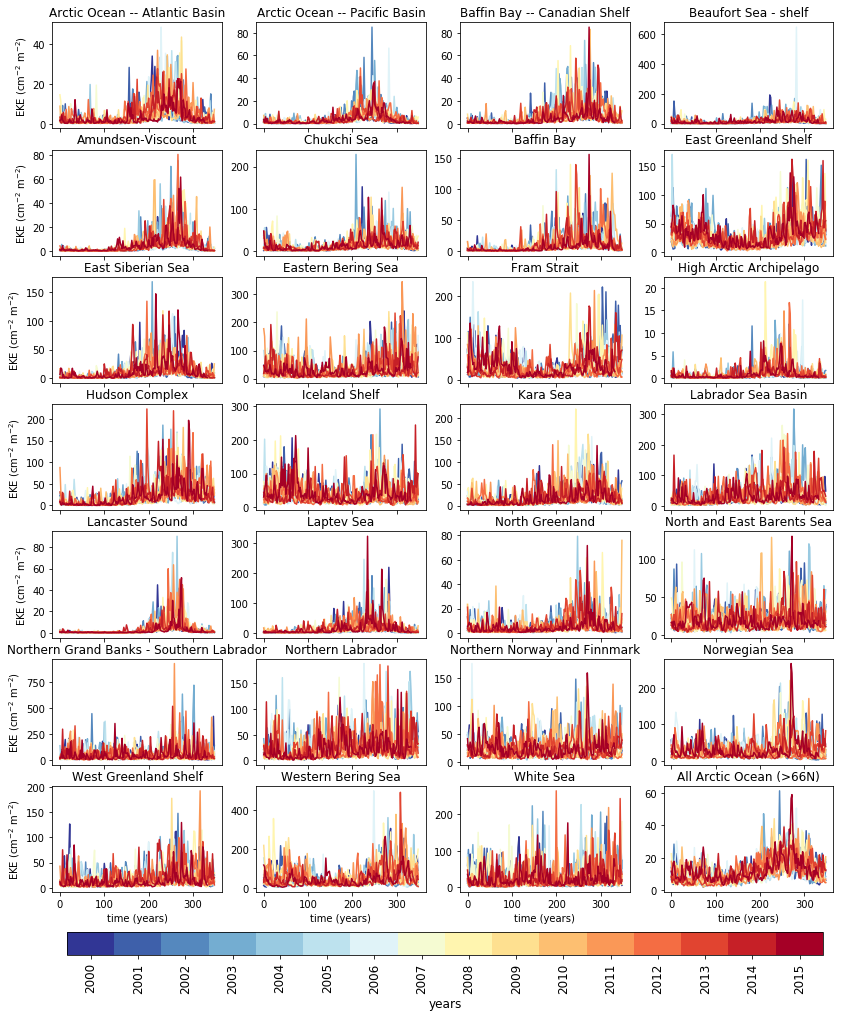

In [9]:
figsize = (14, 16)
rows,cols = 7,4
regions = range(0,28)

fig = plt.figure(figsize=figsize, constrained_layout=False)
axs = fig.subplots(rows,cols,sharey=False,sharex=True)
axs = trim_axs(axs, len(regions))

for ind in range(0,len(years)):
    print years[ind]
    ncfile  = resultpath+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f1       = Dataset(ncfile, 'r')  
    ncfile  = resultpath+runid+'.'+str(years[ind])+'.oce.diag.nc'
    f2       = Dataset(ncfile, 'r') 
    
    u     = f1.variables[var_id1][:,0:mesh.n2d]
    v     = f1.variables[var_id2][:,0:mesh.n2d]
    uu     = f2.variables[var_id3][:,0:mesh.n2d]
    vv     = f2.variables[var_id4][:,0:mesh.n2d]
    ux, vy = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, u, v, flag=1)
    var = 10000*0.5*((uu+vv)-(ux**2+vy**2))  
    
    for ax, bio_id in zip(axs, regions):
        #print names[bio_id]
        if bio_id ==27:
            ind_arc = np.nonzero((mesh.y2>66))
            pp = np.sum(np.squeeze(var[:,ind_arc])*NodalAreaModel[ind_arc], axis=1)/np.sum(NodalAreaModel[ind_arc])
        else:
            #df_lon.lon[df.full_index[index==num_id]]
            ind_arc = df.full_index[df.Unique_ID == bio_id+24]
            pp = np.sum(var[:,ind_arc]*NodalAreaModel[ind_arc], axis=1)/np.sum(NodalAreaModel[ind_arc])
        
        if ((years[ind] >= 2000) & (years[ind]<2015)):
            ax.plot(np.arange(0,350,2),pp, color = cmap(ind))
        elif years[ind] == 2015:
            ax.plot(np.arange(0,334,2),pp, color = cmap(ind))
        elif years[ind] <2000:
            ax.plot(np.arange(15,350,30),pp, color = cmap(ind))
        ax.set_title(names[bio_id])
        
        if bio_id in np.arange(0,28,4):
            ax.set_ylabel('EKE (cm$^{-2}$ m$^{-2}$)')
        if bio_id in np.arange(24,28):
            ax.set_xlabel('time (years)')

fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.14, 0.07, 0.75, 0.02])
norm = matplotlib.colors.BoundaryNorm(np.arange(len(years)+1)+0.5,len(years))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # this line may be ommitted for matplotlib >= 3.1
cb = fig.colorbar(sm, ticks=years, cax=cbar_ax, orientation='horizontal')

cb.ax.tick_params(labelsize='large', rotation=90)
cb.set_label(label='years', size='large')
cb.set_ticks([np.arange(0,37)])
cb.set_ticklabels(years)

plt.show()
fig.savefig(savepath+'seasonal/bioregional_EKE_'+str(first_year)+'_'+str(last_year)+'.png', dpi = dpicnt, bbox_inches='tight')      